# FaultTree

## Install

Use Pkg to install the packages. The packages are located in GitHub. Please run the following commands:

- For Julia 1.0.5
```julia
using Pkg
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/DD.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/FaultTree.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/JuliaDot.jl.git"))
```

In [29]:
using Pkg
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/DD.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/FaultTree.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/JuliaDot.jl.git"))

  Updating git-repo `https://github.com/JuliaReliab/DD.jl.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
  Updating git-repo `https://github.com/JuliaReliab/FaultTree.jl.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
  Updating git-repo `https://github.com/JuliaReliab/JuliaDot.jl.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


## Initialize

Load `FaultTree` and `JuliaDot`. `JuliaDot` provides drawing a graph of fault trees and BDD, but the package `JuliaDot` depends on your own environment. If the loding `JuliaDot` fails, please remove (comment out) loading `JuliaDot`

In [30]:
using FaultTree
using JuliaDot

## Create Fault Trees

### Basic operations

- `ftevent`: create an event in fault tree such as a component failure. The argument is a label of event. The event is distinguished by the label.
- `*` or `&`: AND gate
- `+` or `|`: OR gate
- `!` or `~`: NOT gate
- `ftand(a, b, c, ...)`: AND gate that allows to take multiple events
- `ftor(a, b, c, ...)`: OR gate that allows to take multiple events
- `ftnot(a)`: NOT gate that is same as `!` and `~`
- `ftkofn(k, a, b, c, ...)': K-out-of-N gate where `k` is the number of events that causes the failure

### Example 1

#### Definition of component failure events

In [31]:
x = ftevent("motor failure") # motor failure
y = ftevent("sensor failure") # sensor failure
z = ftevent("battery failure") # battery failure

FaultTreeEvent(Set(Symbol[Symbol("battery failure")]), Symbol("battery failure"))

#### Definition of fault tree to represent the system failure

In [32]:
system = ftor(x, y, z)

FaultTreeOperation(Set(Symbol[Symbol("sensor failure"), Symbol("motor failure"), Symbol("battery failure")]), :OR, AbstractFaultTreeNode[FaultTreeEvent(Set(Symbol[Symbol("motor failure")]), Symbol("motor failure")), FaultTreeEvent(Set(Symbol[Symbol("sensor failure")]), Symbol("sensor failure")), FaultTreeEvent(Set(Symbol[Symbol("battery failure")]), Symbol("battery failure"))])

#### Drawing a brief fault tree. This process requires that `JuliaDot` is successfully installed

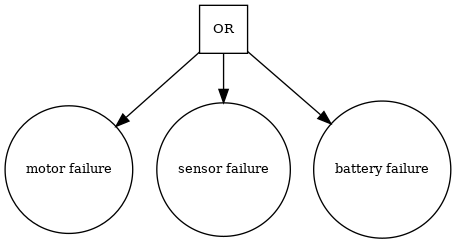

In [33]:
dot(todot(system))

#### Minimal cut set

In [34]:
ftmcs(system)

3-element Array{Array{Symbol,1},1}:
 [Symbol("battery failure")]
 [Symbol("motor failure")]  
 [Symbol("sensor failure")] 

#### Define failure probabilities for compoments

The following defintion uses the ftevent variables. But if we know the symbols for ftevent, we can use them as follows.
```julia
params = Dict(
    Symbol("motor failure") => 0.0001,
    Symbol("sensor failure") => 0.0001,
    Symbol("battery failure") => 0.0001
)
```

In [35]:
params = Dict(
    x.var => 0.001, # failure probability for motor
    y.var => 0.0001, # failure probability for sensor
    z.var => 0.00001  # failure probability for battery
)

Dict{Symbol,Float64} with 3 entries:
  Symbol("sensor failure")  => 0.0001
  Symbol("motor failure")   => 0.001
  Symbol("battery failure") => 1.0e-5

#### Compute the system failure probability

In [36]:
fteval(system, params)

0.0011098890010000002

#### Birunbaum importance measure

In [37]:
# define the derivative for a parameter.
dparams_x = Dict(x.var => 1.0, y.var => 0.0, z.var => 0.0)
dparams_y = Dict(x.var => 0.0, y.var => 1.0, z.var => 0.0)
dparams_z = Dict(x.var => 0.0, y.var => 0.0, z.var => 1.0)

Dict{Symbol,Float64} with 3 entries:
  Symbol("sensor failure")  => 0.0
  Symbol("motor failure")   => 0.0
  Symbol("battery failure") => 1.0

In [38]:
using Printf
@printf("%20s %.5f\n", x.var, fteval(system, params, dparams_x))
@printf("%20s %.5f\n", y.var, fteval(system, params, dparams_y))
@printf("%20s %.5f\n", z.var, fteval(system, params, dparams_z))

       motor failure 0.99989
      sensor failure 0.99899
     battery failure 0.99890


### Example 2

#### Definition of component failure events

In [39]:
x = [ftevent("motor failure ", i) for i = ["arm1", "arm2", "arm3"]]
y = [ftevent("sensor failure ", i) for i = ["left", "right"]]
z = ftevent("battery failure")

FaultTreeEvent(Set(Symbol[Symbol("battery failure")]), Symbol("battery failure"))

#### Definition of fault tree to represent the system failure

In [40]:
sub = [x[i] + z for i = 1:3]
system = ftkofn(2, sub[1], sub[2], sub[3]) + (y[1] * y[2])

FaultTreeOperation(Set(Symbol[Symbol("motor failure arm3"), Symbol("motor failure arm1"), Symbol("sensor failure right"), Symbol("sensor failure left"), Symbol("battery failure"), Symbol("motor failure arm2")]), :OR, AbstractFaultTreeNode[FaultTreeKoutofN(Set(Symbol[Symbol("motor failure arm3"), Symbol("motor failure arm1"), Symbol("battery failure"), Symbol("motor failure arm2")]), :KofN, 2, AbstractFaultTreeNode[FaultTreeOperation(Set(Symbol[Symbol("motor failure arm1"), Symbol("battery failure")]), :OR, AbstractFaultTreeNode[FaultTreeEvent(Set(Symbol[Symbol("motor failure arm1")]), Symbol("motor failure arm1")), FaultTreeEvent(Set(Symbol[Symbol("battery failure")]), Symbol("battery failure"))]), FaultTreeOperation(Set(Symbol[Symbol("motor failure arm2"), Symbol("battery failure")]), :OR, AbstractFaultTreeNode[FaultTreeEvent(Set(Symbol[Symbol("motor failure arm2")]), Symbol("motor failure arm2")), FaultTreeEvent(Set(Symbol[Symbol("battery failure")]), Symbol("battery failure"))]), Fa

#### Drawing a brief fault tree. This process requires that `JuliaDot` is successfully installed

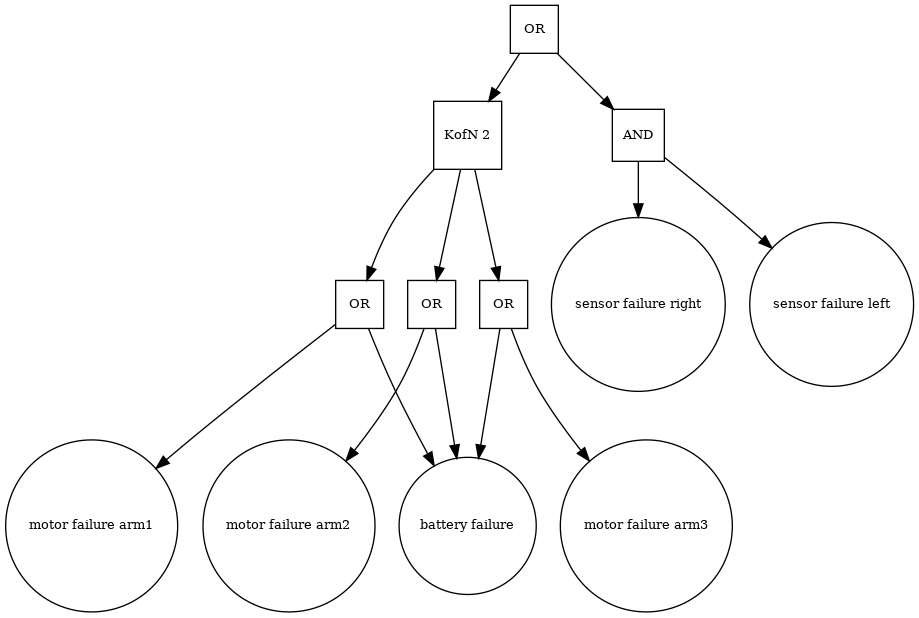

In [41]:
dot(todot(system))

In [42]:
# top, forest = bdd(system)
# dot(todot(forest, top))

#### Minimal cut set

In [43]:
ftmcs(system)

5-element Array{Array{Symbol,1},1}:
 [Symbol("battery failure")]                                    
 [Symbol("motor failure arm1"), Symbol("motor failure arm2")]   
 [Symbol("motor failure arm1"), Symbol("motor failure arm3")]   
 [Symbol("motor failure arm2"), Symbol("motor failure arm3")]   
 [Symbol("sensor failure left"), Symbol("sensor failure right")]

#### Define failure probabilities for compoments

In [44]:
params = Dict(
    [x[i].var => 0.001 for i = 1:3]...,
    [y[i].var => 0.0001 for i = 1:2]...,
    z.var => 0.00001
)

Dict{Symbol,Float64} with 6 entries:
  Symbol("motor failure arm3")   => 0.001
  Symbol("motor failure arm1")   => 0.001
  Symbol("sensor failure right") => 0.0001
  Symbol("sensor failure left")  => 0.0001
  Symbol("motor failure arm2")   => 0.001
  Symbol("battery failure")      => 1.0e-5

#### Compute the system failure probability

In [45]:
fteval(system, params)

1.3007969890020301e-5

#### Birunbaum importance measure

In [46]:
# define the derivative for a parameter.
dparams_x1 = Dict(x[1].var => 1.0, x[2].var => 0.0, x[3].var => 0.0, y[1].var => 0.0, y[2].var => 0.0, z.var => 0.0)
dparams_x2 = Dict(x[1].var => 0.0, x[2].var => 1.0, x[3].var => 0.0, y[1].var => 0.0, y[2].var => 0.0, z.var => 0.0)
dparams_x3 = Dict(x[1].var => 0.0, x[2].var => 0.0, x[3].var => 1.0, y[1].var => 0.0, y[2].var => 0.0, z.var => 0.0)
dparams_y1 = Dict(x[1].var => 0.0, x[2].var => 0.0, x[3].var => 0.0, y[1].var => 1.0, y[2].var => 0.0, z.var => 0.0)
dparams_y2 = Dict(x[1].var => 0.0, x[2].var => 0.0, x[3].var => 0.0, y[1].var => 0.0, y[2].var => 1.0, z.var => 0.0)
dparams_z = Dict(x[1].var => 0.0, x[2].var => 0.0, x[3].var => 0.0, y[1].var => 0.0, y[2].var => 0.0, z.var => 1.0)

Dict{Symbol,Float64} with 6 entries:
  Symbol("motor failure arm3")   => 0.0
  Symbol("motor failure arm1")   => 0.0
  Symbol("sensor failure right") => 0.0
  Symbol("sensor failure left")  => 0.0
  Symbol("motor failure arm2")   => 0.0
  Symbol("battery failure")      => 1.0

In [47]:
# importance for x
using Printf
@printf("%20s %.5f\n", x[1].var, fteval(system, params, dparams_x1))
@printf("%20s %.5f\n", x[2].var, fteval(system, params, dparams_x2))
@printf("%20s %.5f\n", x[3].var, fteval(system, params, dparams_x3))
@printf("%20s %.5f\n", y[1].var, fteval(system, params, dparams_y1))
@printf("%20s %.5f\n", y[2].var, fteval(system, params, dparams_y2))
@printf("%20s %.5f\n", z.var, fteval(system, params, dparams_z))

  motor failure arm1 0.00200
  motor failure arm2 0.00200
  motor failure arm3 0.00200
 sensor failure left 0.00010
sensor failure right 0.00010
     battery failure 1.00000


### Example 3 (Wrong example for Example 2)

#### Definition of component failure events

In [48]:
x = ftevent("motor failure")
y = ftevent("sensor failure")
z = ftevent("battery failure")

FaultTreeEvent(Set(Symbol[Symbol("battery failure")]), Symbol("battery failure"))

#### Definition of fault tree to represent the system failure

In [49]:
sub = x + z
system = ftkofn(2, sub, sub, sub) + (y * y) ## sub and y are not redundant!

FaultTreeOperation(Set(Symbol[Symbol("sensor failure"), Symbol("motor failure"), Symbol("battery failure")]), :OR, AbstractFaultTreeNode[FaultTreeKoutofN(Set(Symbol[Symbol("motor failure"), Symbol("battery failure")]), :KofN, 2, AbstractFaultTreeNode[FaultTreeOperation(Set(Symbol[Symbol("motor failure"), Symbol("battery failure")]), :OR, AbstractFaultTreeNode[FaultTreeEvent(Set(Symbol[Symbol("motor failure")]), Symbol("motor failure")), FaultTreeEvent(Set(Symbol[Symbol("battery failure")]), Symbol("battery failure"))]), FaultTreeOperation(Set(Symbol[Symbol("motor failure"), Symbol("battery failure")]), :OR, AbstractFaultTreeNode[FaultTreeEvent(Set(Symbol[Symbol("motor failure")]), Symbol("motor failure")), FaultTreeEvent(Set(Symbol[Symbol("battery failure")]), Symbol("battery failure"))]), FaultTreeOperation(Set(Symbol[Symbol("motor failure"), Symbol("battery failure")]), :OR, AbstractFaultTreeNode[FaultTreeEvent(Set(Symbol[Symbol("motor failure")]), Symbol("motor failure")), FaultTree

#### Drawing a brief fault tree. This process requires that `JuliaDot` is successfully installed

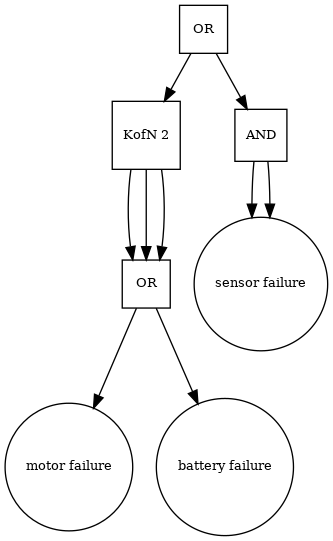

In [50]:
dot(todot(system))

In [51]:
# top, forest = bdd(system)
# dot(todot(forest, top))

#### Minimal cut set

In [52]:
ftmcs(system)

3-element Array{Array{Symbol,1},1}:
 [Symbol("battery failure")]
 [Symbol("motor failure")]  
 [Symbol("sensor failure")] 

#### Define failure probabilities for compoments

In [53]:
params = Dict(
    x.var => 0.001,
    y.var => 0.0001,
    z.var => 0.00001
)

Dict{Symbol,Float64} with 3 entries:
  Symbol("sensor failure")  => 0.0001
  Symbol("motor failure")   => 0.001
  Symbol("battery failure") => 1.0e-5

#### Compute the system failure probability

In [54]:
fteval(system, params)

0.0011098890010000002

#### Birunbaum importance measure

In [55]:
# define the derivative for a parameter.
dparams_x = Dict(x.var => 1.0, y.var => 0.0, z.var => 0.0)
dparams_y = Dict(x.var => 0.0, y.var => 1.0, z.var => 0.0)
dparams_z = Dict(x.var => 0.0, y.var => 0.0, z.var => 1.0)

Dict{Symbol,Float64} with 3 entries:
  Symbol("sensor failure")  => 0.0
  Symbol("motor failure")   => 0.0
  Symbol("battery failure") => 1.0

In [56]:
# importance for x
using Printf
@printf("%20s %.5f\n", x.var, fteval(system, params, dparams_x))
@printf("%20s %.5f\n", y.var, fteval(system, params, dparams_y))
@printf("%20s %.5f\n", z.var, fteval(system, params, dparams_z))

       motor failure 0.99989
      sensor failure 0.99899
     battery failure 0.99890
